In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import display
import scipy.stats as stats
import random
import itertools

# Import our custom function modules
import sampler_functions as sf
import outlier_functions as oef

# Set a nice plot style
sns.set_theme(style="whitegrid")
print("Libraries and modules imported successfully.")

Libraries and modules imported successfully.


In [17]:
# --- 1. Define Experiment Parameters ---

params = {
    'm': 10,
    'k': 2.0,
    'mu_true': 10.0,
    'prior_mean': 0.0,
    'prior_std': 20.0,
    'num_iterations_T': 30000, 
    'proposal_std_mu': 0.9,
    'proposal_std_z': 0.2
}

# Add z_domain to params, as it depends on k
z_domain_half_width = 1 / (2 * np.sqrt(params['k']))
params['z_domain'] = (-z_domain_half_width, z_domain_half_width)

print("Parameters for this run:")
print(params)

Parameters for this run:
{'m': 10, 'k': 2.0, 'mu_true': 10.0, 'prior_mean': 0.0, 'prior_std': 20.0, 'num_iterations_T': 30000, 'proposal_std_mu': 0.9, 'proposal_std_z': 0.2, 'z_domain': (np.float64(-0.35355339059327373), np.float64(0.35355339059327373))}


In [12]:
# Generate a single "clean" dataset with its MLE centered at mu_true
print("--- Generating Clean, Centered Dataset ---")
x1_clean = sf.generate_clean_dataset_centered(params)
print("Clean dataset generated successfully.")
print(f"Verified MLE of clean dataset: {sf.get_mle(x1_clean, params):.6f}\n")


# --- NEW SEQUENTIAL GENERATION LOGIC ---
print("\n--- Generating 5 Sequential Outlier Datasets ---")
outlier_datasets = []
num_outlier_sets_to_generate = 5

# Start with the clean dataset as the base for the first modification
current_dataset = x1_clean.copy() 
# Keep track of indices that are still "clean" and can be modified
available_indices = list(range(params['m']))

for i in range(num_outlier_sets_to_generate):
    # Check if we have enough clean points left to form a pair
    if len(available_indices) < 2:
        print(f"Not enough available indices to continue. Generated {i} outlier sets.")
        break

    print(f"--- Generating Outlier Set {i+1} (Total non-clean points: {(i+1)*2}) ---")
    
    # Randomly select two available indices to form the new pair
    indices_to_update = tuple(random.sample(available_indices, 2))
    idx1, idx2 = indices_to_update
    
    # Generate the next outlier dataset based on the CURRENT one
    x_outlier = sf.generate_constrained_outlier_pair(
        clean_dataset=current_dataset,
        indices=indices_to_update,
        mu_star=params['mu_true'],
        k=params['k'],
        params=params
    )
    
    if x_outlier is not None:
        # Add the new dataset to our list
        outlier_datasets.append(x_outlier)
        
        # --- ADDED PRINT STATEMENTS ---
        original_val1 = current_dataset[idx1]
        original_val2 = current_dataset[idx2]
        new_val1 = x_outlier[idx1]
        new_val2 = x_outlier[idx2]
        print(f"  Modifying indices: ({idx1}, {idx2})")
        print(f"  Original values: x[{idx1}]={original_val1:.2f}, x[{idx2}]={original_val2:.2f}")
        print(f"  New values:      x[{idx1}]={new_val1:.2f}, x[{idx2}]={new_val2:.2f}")
        
        # --- CORRECTED VERIFICATION STEP ---
        # Instead of re-calculating the MLE, we verify that the score at mu_true is ~0.
        # This is more stable than root-finding on a complex distribution.
        score_at_mu_true = sf.mle_score(params['mu_true'], x_outlier, params['k'])
        print(f"  Score at mu_true={params['mu_true']:.1f}: {score_at_mu_true:.6e}\n")

        # Update the current dataset for the next iteration
        current_dataset = x_outlier.copy()
        
        # Remove the used indices from the available pool
        available_indices.remove(idx1)
        available_indices.remove(idx2)
    else:
        print(f"Failed to generate a valid pair for indices ({idx1}, {idx2}). Stopping generation.")
        break

print(f"\nSuccessfully generated {len(outlier_datasets)} sequential outlier datasets.")



--- Generating Clean, Centered Dataset ---
Calculating MLE for data with 10 points and k=2.0...
Clean dataset generated successfully.
Calculating MLE for data with 10 points and k=2.0...
Verified MLE of clean dataset: 10.000000


--- Generating 5 Sequential Outlier Datasets ---
--- Generating Outlier Set 1 (Total non-clean points: 2) ---
  Modifying indices: (8, 6)
  Original values: x[8]=10.58, x[6]=9.94
  New values:      x[8]=-6.24, x[6]=10.70
  Score at mu_true=10.0: -4.936052e-13

--- Generating Outlier Set 2 (Total non-clean points: 4) ---
  Modifying indices: (3, 2)
  Original values: x[3]=10.13, x[2]=10.06
  New values:      x[3]=-6.83, x[2]=10.33
  Score at mu_true=10.0: -4.932166e-13

--- Generating Outlier Set 3 (Total non-clean points: 6) ---
  Modifying indices: (1, 9)
  Original values: x[1]=10.14, x[9]=9.90
  New values:      x[1]=24.63, x[9]=9.90
  Score at mu_true=10.0: -4.935288e-13

--- Generating Outlier Set 4 (Total non-clean points: 8) ---
  Modifying indices: (7,


--- Visualizing Datasets ---


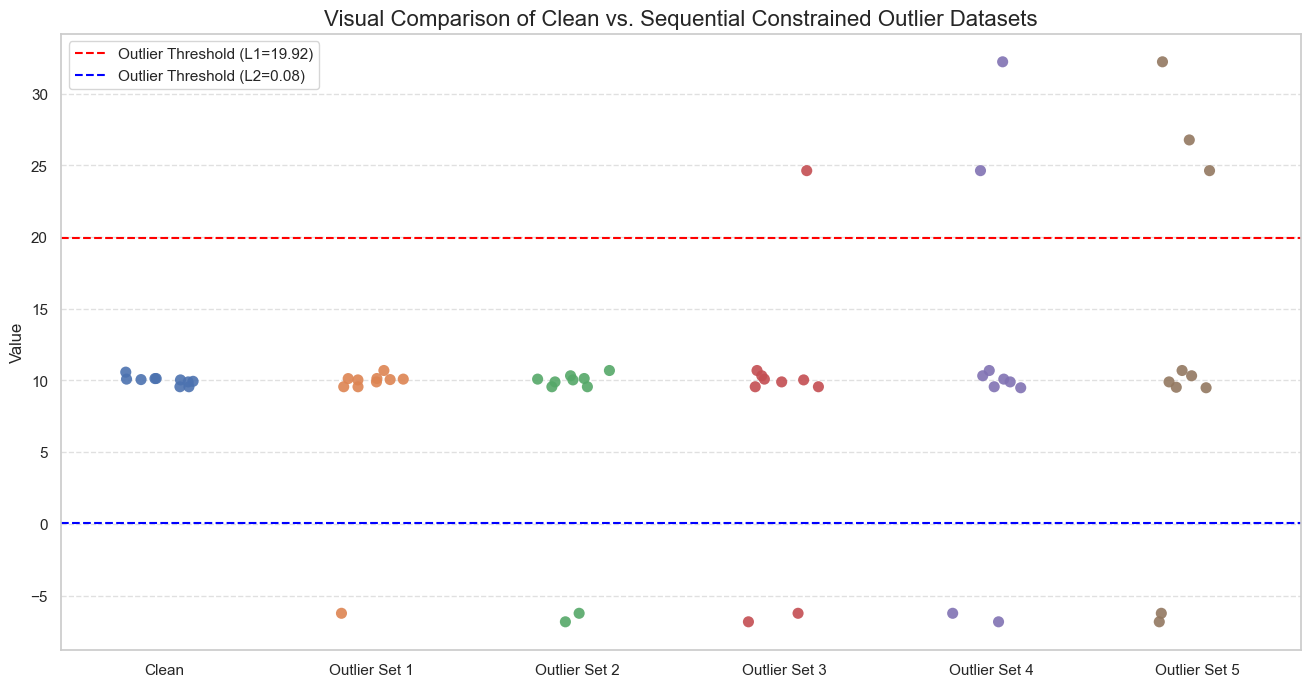

In [13]:
# --- Visualize the generated datasets ---
print("\n--- Visualizing Datasets ---")
plt.figure(figsize=(16, 8))

# Combine all datasets for plotting
all_datasets_for_plot = [x1_clean] + outlier_datasets
labels = ['Clean'] + [f'Outlier Set {i+1}' for i in range(len(outlier_datasets))]

# Create the strip plot to visualize all datasets at once
sns.stripplot(data=all_datasets_for_plot, size=8, jitter=0.2, alpha=0.9)

# Define an outlier threshold just for visualization purposes
outlier_threshold_L1 = stats.t.ppf(0.995, df=params['k'], loc=params['mu_true'], scale=1)
plt.axhline(outlier_threshold_L1, color='red', linestyle='--', 
            label=f'Outlier Threshold (L1={outlier_threshold_L1:.2f})')

outlier_threshold_L2 = stats.t.ppf(0.005, df=params['k'], loc=params['mu_true'], scale=1)
plt.axhline(outlier_threshold_L2, color='blue', linestyle='--', 
            label=f'Outlier Threshold (L2={outlier_threshold_L2:.2f})')

# Final plot styling
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.ylabel("Value", fontsize=12)
plt.title("Visual Comparison of Clean vs. Sequential Constrained Outlier Datasets", fontsize=16)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [48]:
# --- 4. Compute Benchmark KDE Posterior ---
print("\n--- Computing Benchmark KDE for p(μ̂ | μ=0) ---")
# This is computationally expensive, so it's best to run it once.
# This calls a function assumed to be in sampler_functions.py
kde_0 = sf.compute_benchmark_kde(params, num_simulations=50000)
print("Benchmark KDE computed.")





--- Computing Benchmark KDE for p(μ̂ | μ=0) ---

--- Computing Benchmark KDE from 50000 simulations ---
(This is computationally intensive and will take some time...)


Building Benchmark KDE: 100%|██████████| 50000/50000 [04:15<00:00, 195.52it/s]

Benchmark KDE computed successfully.
Benchmark KDE computed.


In [51]:
import os
import pickle
results_path = os.path.join(
        "results_outlier_new")

print(f"Results will be saved to: {results_path}")
len(kde_0)

Results will be saved to: results_outlier_new


TypeError: object of type 'gaussian_kde' has no len()

In [53]:
import pickle
import os

# --- 4. Compute or Load Benchmark KDE ---
print("\n--- Loading/Computing Benchmark KDE for p(μ̂ | μ=0) ---")

# Define the path where the results will be stored
results_path = "results_outlier_new" 
# *** ADD THIS LINE TO CREATE THE DIRECTORY ***
os.makedirs(results_path, exist_ok=True)

# Define the full path for the saved KDE object
kde_save_path = os.path.join(results_path, "kde_0_benchmark.pkl")

# Check if the file already exists
if os.path.exists(kde_save_path):
    # If it exists, load the pre-computed object
    print(f"Loading pre-computed benchmark KDE from: {kde_save_path}")
    with open(kde_save_path, 'rb') as f:
        kde_0 = pickle.load(f)
else:
    # If it doesn't exist, run the expensive computation
    print("No pre-computed KDE found. Running simulation...")
    kde_0 = sf.compute_benchmark_kde(params, num_simulations=50000)
    
    # Save the newly computed object for future runs
    with open(kde_save_path, 'wb') as f:
        pickle.dump(kde_0, f)
    print(f"Benchmark KDE computed and saved to: {kde_save_path}")

print("Benchmark KDE is ready.")


--- Loading/Computing Benchmark KDE for p(μ̂ | μ=0) ---
No pre-computed KDE found. Running simulation...

--- Computing Benchmark KDE from 50000 simulations ---
(This is computationally intensive and will take some time...)


Building Benchmark KDE: 100%|██████████| 50000/50000 [04:16<00:00, 195.13it/s]

Benchmark KDE computed successfully.


AttributeError: Can't pickle local object 'gaussian_kde.set_bandwidth.<locals>.<lambda>'

In [ ]:
print("\n--- Calculating Benchmark Posterior ---")
# Since MLE is fixed at mu_true for all our datasets, this is constant.
mu_grid = np.linspace(params['mu_true'] - 8, params['mu_true'] + 8, 1000)
# The likelihood p(μ̂ | μ) is equivalent to p(μ̂ - μ | 0).
# So, p(μ̂=10 | μ) is equivalent to p(μ̂=10-μ | 0).
likelihood_kde = kde_0.pdf(params['mu_true'] - mu_grid)
prior_on_grid = stats.norm.pdf(mu_grid, loc=params['prior_mean'], scale=params['prior_std'])
unnormalized_posterior_kde = likelihood_kde * prior_on_grid
area = np.trapezoid(unnormalized_posterior_kde, mu_grid)
benchmark_posterior = unnormalized_posterior_kde / area
print("Benchmark posterior calculated successfully.")


# --- 5. Compute Full Data Posteriors for All Datasets ---
print("\n--- Generating Full Data Posterior Samples for Each Dataset ---")
all_datasets = [x1_clean] + outlier_datasets
posterior_chains = []
for i, dataset in enumerate(all_datasets):
    if i == 0:
        print(f"Running sampler for Clean Dataset...")
    else:
        print(f"Running sampler for Outlier Set {i}...")
    # This calls the function from outlier_functions.py
    chain = oef.get_full_data_posterior_samples(dataset, params)
    posterior_chains.append(chain)
print("All posterior chains generated.")



/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_42331/1181596821.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(unnormalized_posterior_kde, mu_grid)



--- Calculating Benchmark Posterior ---
Benchmark posterior calculated successfully.

--- Generating Full Data Posterior Samples for Each Dataset ---
Running sampler for Clean Dataset...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5514.21it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 1...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5479.86it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 2...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5548.00it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 3...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5727.21it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 4...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5674.31it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 5...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5706.04it/s]

Full-data posterior sampling complete.
All posterior chains generated.



--- Visualizing Posterior Distributions ---


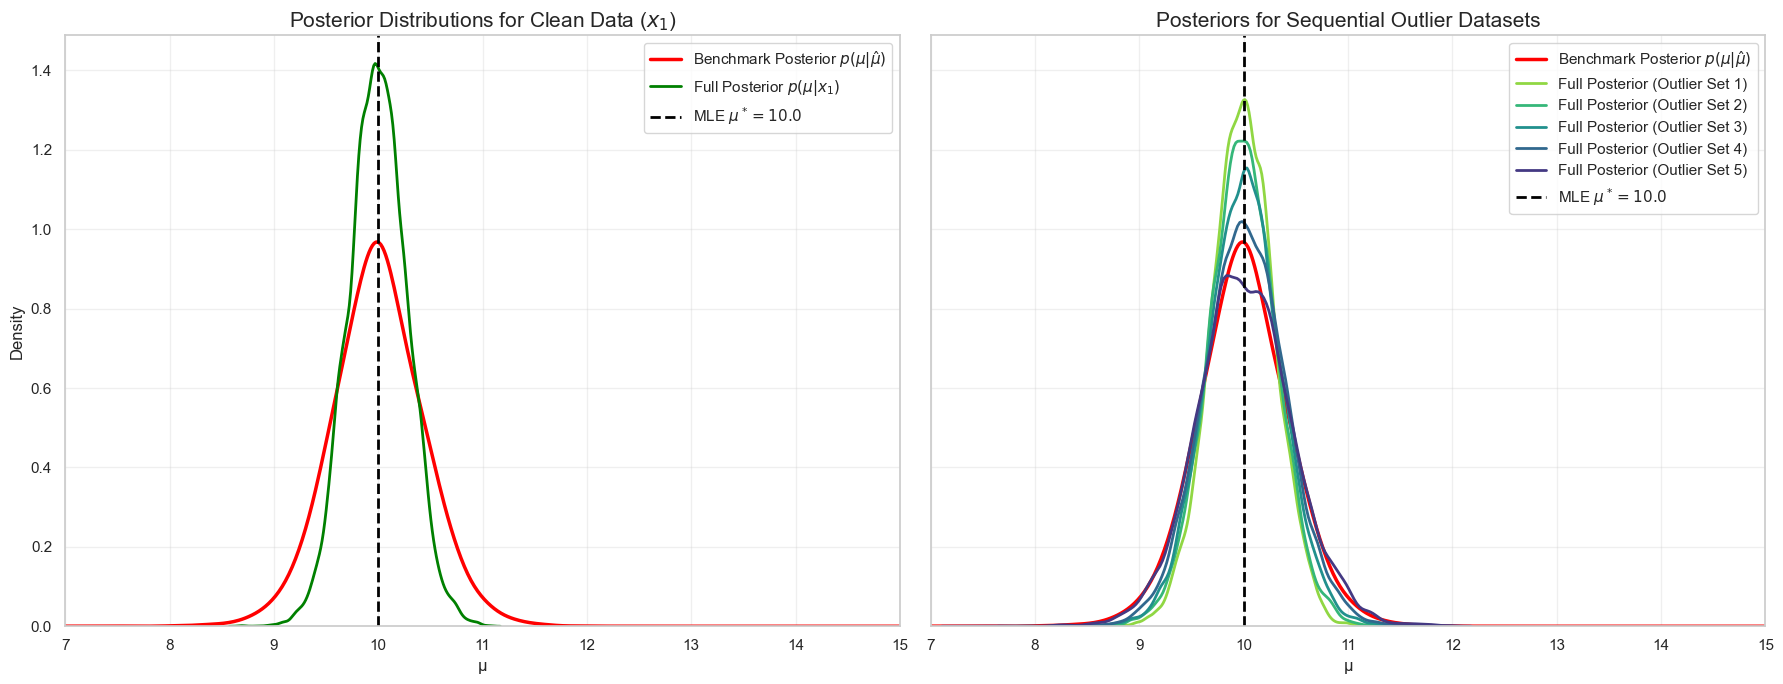

In [21]:
# --- 6. Visualize the Posterior Distributions ---
print("\n--- Visualizing Posterior Distributions ---")
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
colors = sns.color_palette("viridis_r", n_colors=len(outlier_datasets))

# --- Left Panel: Clean Dataset Analysis ---
# Plot the benchmark posterior p(μ|μ̂)
axes[0].plot(mu_grid, benchmark_posterior, color='red', linestyle='-', lw=2.5, label="Benchmark Posterior $p(μ|μ̂)$")
# Plot the full data posterior p(μ|x₁)
sns.kdeplot(posterior_chains[0], label="Full Posterior $p(μ|x_1)$", color='green', lw=2, ax=axes[0], bw_method='scott')
# Add a vertical line for the constant MLE
axes[0].axvline(params['mu_true'], color='black', linestyle='--', lw=2, label=f"MLE $\\mu^* = {params['mu_true']:.1f}$")
axes[0].set_title("Posterior Distributions for Clean Data ($x_1$)", fontsize=15)
axes[0].set_xlabel("μ")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(alpha=0.3)


# --- Right Panel: Outlier Datasets Analysis ---
# Plot the benchmark posterior p(μ|μ̂)
axes[1].plot(mu_grid, benchmark_posterior, color='red', linestyle='-', lw=2.5, label="Benchmark Posterior $p(μ|μ̂)$")
# Plot the full data posteriors for each outlier set
for i, chain in enumerate(posterior_chains[1:]):
    sns.kdeplot(chain, label=f"Full Posterior (Outlier Set {i+1})", color=colors[i], lw=2, ax=axes[1], bw_method='scott')
# Add a vertical line for the constant MLE
axes[1].axvline(params['mu_true'], color='black', linestyle='--', lw=2, label=f"MLE $\\mu^* = {params['mu_true']:.1f}$")
axes[1].set_title("Posteriors for Sequential Outlier Datasets", fontsize=15)
axes[1].set_xlabel("μ")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Set a consistent, zoomed-in x-axis for both plots
axes[0].set_xlim(7, 15)
axes[1].set_xlim(7, 15)

plt.tight_layout()
plt.show()



--- Visualizing Datasets ---


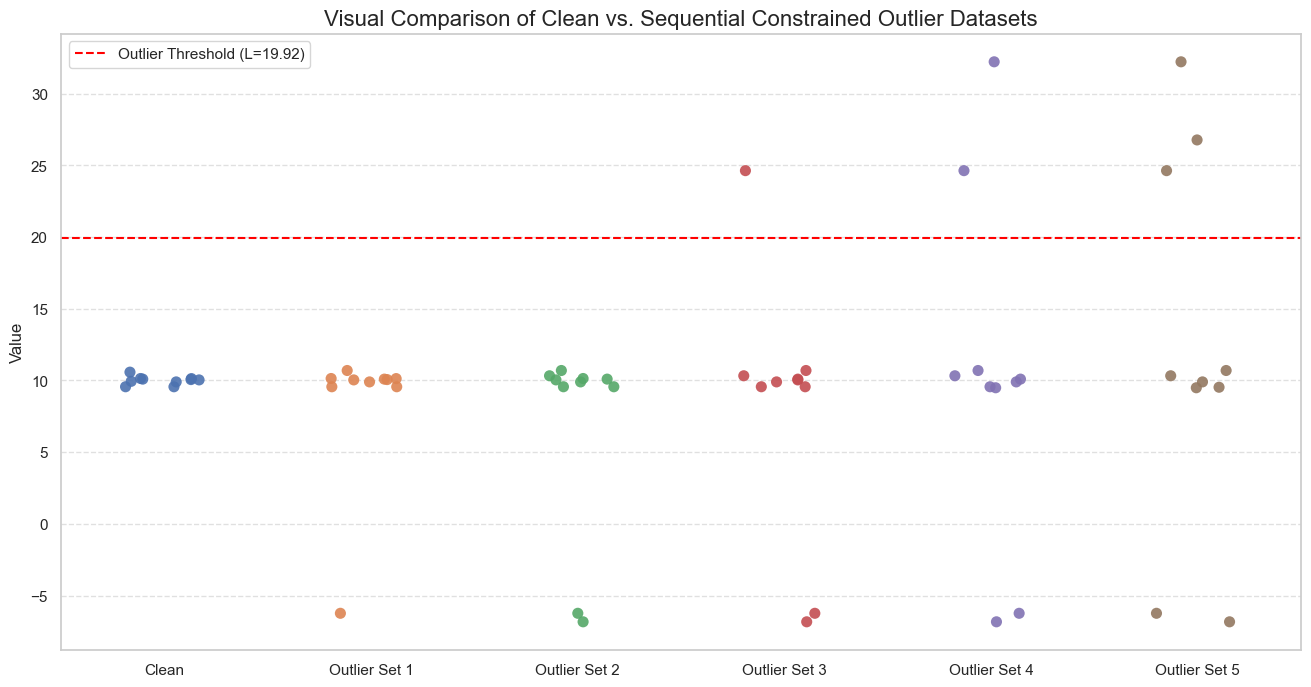


--- Computing Benchmark KDE for p(μ̂ | μ=0) ---

--- Computing Benchmark KDE from 10000 simulations ---
(This is computationally intensive and will take some time...)


Building Benchmark KDE: 100%|██████████| 10000/10000 [00:50<00:00, 199.21it/s]
/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_42331/87325889.py:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(unnormalized_posterior_kde, mu_grid)


Benchmark KDE computed successfully.
Benchmark KDE computed.

--- Calculating Benchmark Posterior ---
Benchmark posterior calculated successfully.

--- Generating Full Data Posterior Samples for Each Dataset ---
Running sampler for Clean Dataset...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5820.23it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 1...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5879.61it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 2...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5909.78it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 3...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5897.17it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 4...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5877.59it/s]


Full-data posterior sampling complete.
Running sampler for Outlier Set 5...

--- Running Sampler for Full-Data Posterior p(μ|x) ---


Sampling p(μ|x): 100%|██████████| 29999/29999 [00:05<00:00, 5922.14it/s]
/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_42331/87325889.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_area = np.trapz(unnormalized_posterior_full, mu_grid)


Full-data posterior sampling complete.
All posterior chains generated.

--- Visualizing Posterior Distributions ---


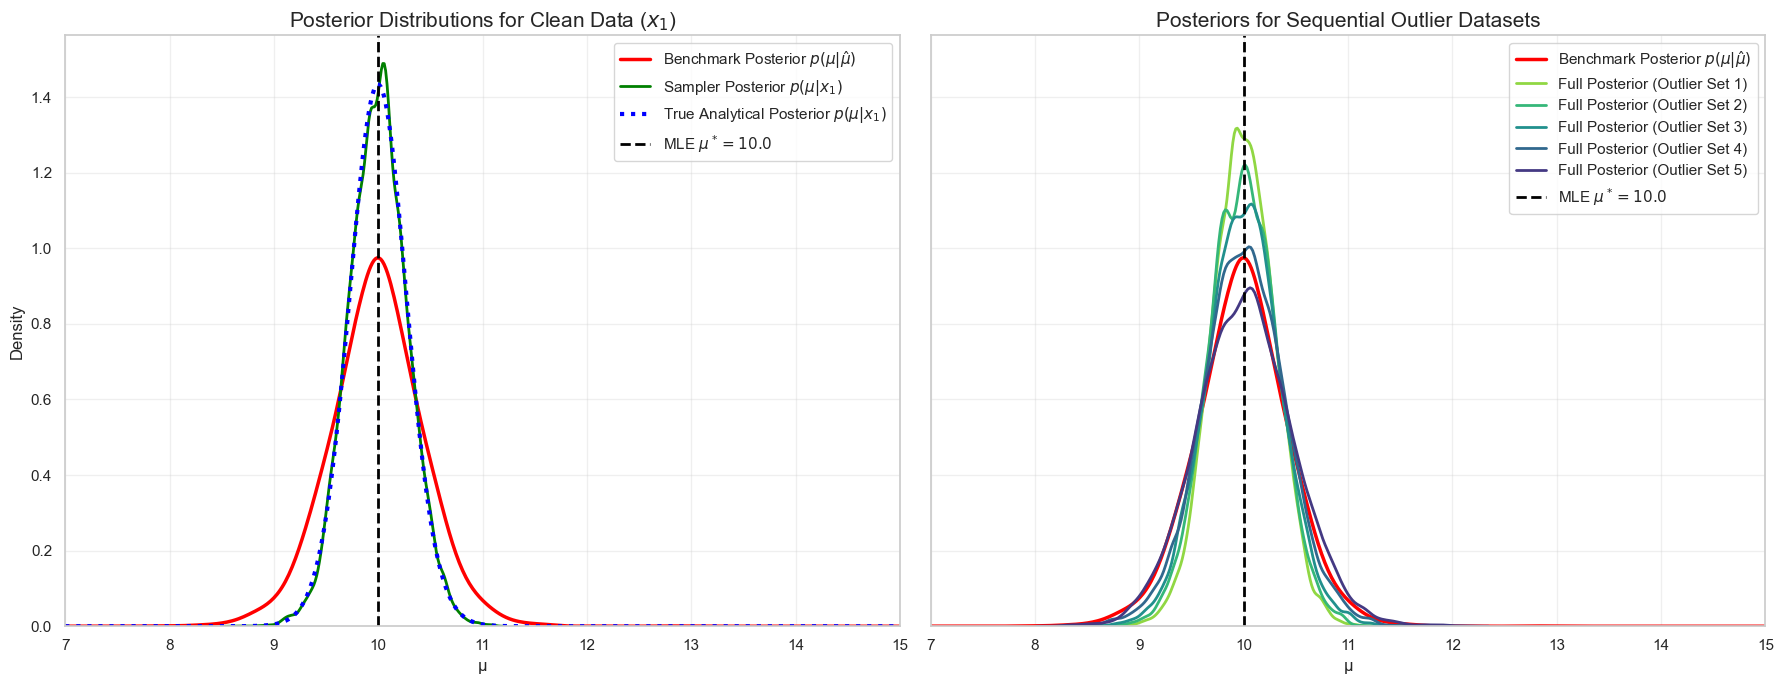

In [54]:
# --- Visualize the generated datasets ---
print("\n--- Visualizing Datasets ---")
plt.figure(figsize=(16, 8))

# Combine all datasets for plotting
all_datasets_for_plot = [x1_clean] + outlier_datasets
labels = ['Clean'] + [f'Outlier Set {i+1}' for i in range(len(outlier_datasets))]

# Create the strip plot to visualize all datasets at once
sns.stripplot(data=all_datasets_for_plot, size=8, jitter=0.2, alpha=0.9)

# Define an outlier threshold just for visualization purposes
outlier_threshold_L = stats.t.ppf(0.995, df=params['k'], loc=params['mu_true'], scale=1)
plt.axhline(outlier_threshold_L, color='red', linestyle='--', 
            label=f'Outlier Threshold (L={outlier_threshold_L:.2f})')

# Final plot styling
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.ylabel("Value", fontsize=12)
plt.title("Visual Comparison of Clean vs. Sequential Constrained Outlier Datasets", fontsize=16)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# --- NEW SECTION: POSTERIOR ANALYSIS ---

# --- 4. Compute Benchmark KDE Posterior ---
print("\n--- Computing Benchmark KDE for p(μ̂ | μ=0) ---")
# This is computationally expensive, so it's best to run it once.
# This calls a function assumed to be in sampler_functions.py
kde_0 = sf.compute_benchmark_kde(params)
print("Benchmark KDE computed.")

print("\n--- Calculating Benchmark Posterior ---")
# Since MLE is fixed at mu_true for all our datasets, this is constant.
mu_grid = np.linspace(params['mu_true'] - 8, params['mu_true'] + 8, 1000)
# The likelihood p(μ̂ | μ) is equivalent to p(μ̂ - μ | 0).
# So, p(μ̂=10 | μ) is equivalent to p(μ̂=10-μ | 0).
likelihood_kde = kde_0.pdf(params['mu_true'] - mu_grid)
prior_on_grid = stats.norm.pdf(mu_grid, loc=params['prior_mean'], scale=params['prior_std'])
unnormalized_posterior_kde = likelihood_kde * prior_on_grid
area = np.trapz(unnormalized_posterior_kde, mu_grid)
benchmark_posterior = unnormalized_posterior_kde / area
print("Benchmark posterior calculated successfully.")


# --- 5. Compute Full Data Posteriors for All Datasets ---
print("\n--- Generating Full Data Posterior Samples for Each Dataset ---")
all_datasets = [x1_clean] + outlier_datasets
posterior_chains = []
for i, dataset in enumerate(all_datasets):
    if i == 0:
        print(f"Running sampler for Clean Dataset...")
    else:
        print(f"Running sampler for Outlier Set {i}...")
    # This calls the function from outlier_functions.py
    chain = oef.get_full_data_posterior_samples(dataset, params)
    posterior_chains.append(chain)
print("All posterior chains generated.")


# --- 6. Visualize the Posterior Distributions ---
print("\n--- Visualizing Posterior Distributions ---")

# --- Calculate the True Analytical Posterior for the clean dataset ---
# This uses the log_posterior_mu function assumed to be in sampler_functions.py
log_posterior_vals = [sf.log_posterior_mu(mu, x1_clean, params['k'], params['prior_mean'], params['prior_std']) for mu in mu_grid]
# Subtract max for numerical stability before exponentiating
unnormalized_posterior_full = np.exp(log_posterior_vals - np.max(log_posterior_vals))
# Normalize the area to 1
integral_area = np.trapz(unnormalized_posterior_full, mu_grid)
true_posterior_full_data = unnormalized_posterior_full / integral_area

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
colors = sns.color_palette("viridis_r", n_colors=len(outlier_datasets))

# --- Left Panel: Clean Dataset Analysis ---
# Plot the benchmark posterior p(μ|μ̂)
axes[0].plot(mu_grid, benchmark_posterior, color='red', linestyle='-', lw=2.5, label="Benchmark Posterior $p(μ|μ̂)$")
# Plot the full data posterior from the sampler p(μ|x₁)
sns.kdeplot(posterior_chains[0], label="Sampler Posterior $p(μ|x_1)$", color='green', lw=2, ax=axes[0], bw_method='scott')
# Plot the true analytical posterior p(μ|x₁)
axes[0].plot(mu_grid, true_posterior_full_data, color='blue', linestyle=':', lw=3, label="True Analytical Posterior $p(μ|x_1)$")
# Add a vertical line for the constant MLE
axes[0].axvline(params['mu_true'], color='black', linestyle='--', lw=2, label=f"MLE $\\mu^* = {params['mu_true']:.1f}$")
axes[0].set_title("Posterior Distributions for Clean Data ($x_1$)", fontsize=15)
axes[0].set_xlabel("μ")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(alpha=0.3)


# --- Right Panel: Outlier Datasets Analysis ---
# Plot the benchmark posterior p(μ|μ̂)
axes[1].plot(mu_grid, benchmark_posterior, color='red', linestyle='-', lw=2.5, label="Benchmark Posterior $p(μ|μ̂)$")
# Plot the full data posteriors for each outlier set
for i, chain in enumerate(posterior_chains[1:]):
    sns.kdeplot(chain, label=f"Full Posterior (Outlier Set {i+1})", color=colors[i], lw=2, ax=axes[1], bw_method='scott')
# Add a vertical line for the constant MLE
axes[1].axvline(params['mu_true'], color='black', linestyle='--', lw=2, label=f"MLE $\\mu^* = {params['mu_true']:.1f}$")
axes[1].set_title("Posteriors for Sequential Outlier Datasets", fontsize=15)
axes[1].set_xlabel("μ")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Set a consistent, zoomed-in x-axis for both plots
axes[0].set_xlim(7, 15)
axes[1].set_xlim(7, 15)

plt.tight_layout()
plt.show()


In [22]:
# --- 6. Generate Posterior Predictive Distributions ---
print("\n--- Generating Posterior Predictive Distributions ---")
predictive_chains = []
# Model parameters
k = params['k']
scale = 1
m = params['m']

for i, mu_chain in enumerate(posterior_chains):
    if i == 0:
        print(f"Generating predictive samples for Clean Dataset chain...")
    else:
        print(f"Generating predictive samples for Outlier Set {i} chain...")
    
    # For each mu in the posterior chain, generate a new dataset of size m
    predictive_datasets = [stats.t.rvs(df=k, loc=mu, scale=scale, size=m) for mu in mu_chain]
    
    # Flatten the list of datasets into a single array of predictive samples
    x_pred = np.array(predictive_datasets).flatten()
    predictive_chains.append(x_pred)

print("All posterior predictive chains generated.")





--- Generating Posterior Predictive Distributions ---
Generating predictive samples for Clean Dataset chain...
Generating predictive samples for Outlier Set 1 chain...
Generating predictive samples for Outlier Set 2 chain...
Generating predictive samples for Outlier Set 3 chain...
Generating predictive samples for Outlier Set 4 chain...
Generating predictive samples for Outlier Set 5 chain...
All posterior predictive chains generated.



--- Calculating Benchmark Posterior ---
Benchmark posterior calculated successfully.

--- Generating Samples from Benchmark Posterior ---
Samples from benchmark posterior generated.

--- Generating Predictive Chain from MLE's Posterior ---


/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_42331/2866924002.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(unnormalized_posterior_kde, mu_grid)


Predictive chain from MLE's posterior generated.

--- Visualizing Posterior Predictive Distributions ---
Upper threshold L1 (99.5%) = 19.92
Lower threshold L2 (0.5%) = 0.08


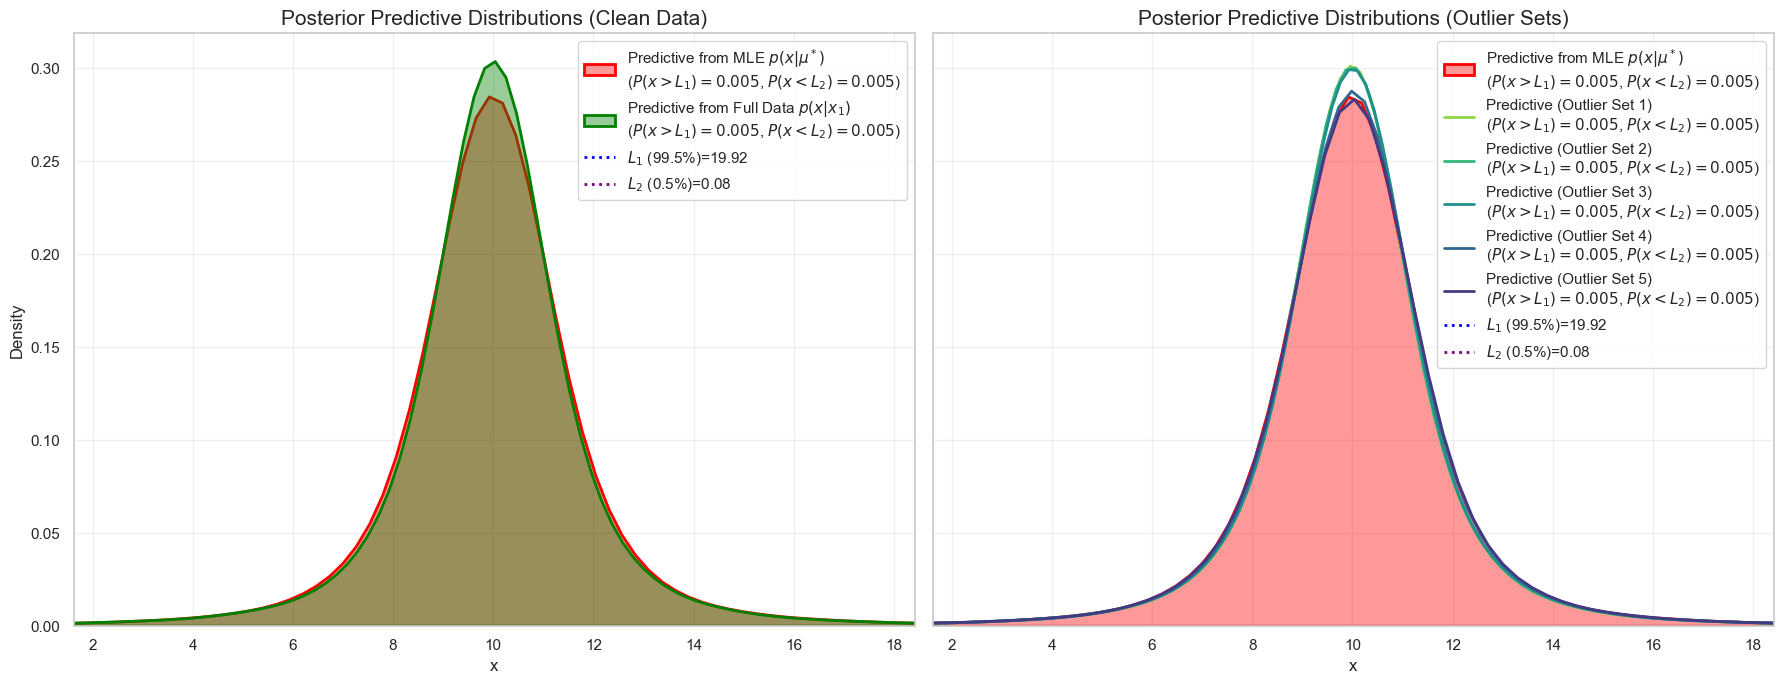

In [47]:
# --- 7. Generate Predictive Chain from Benchmark Posterior ---

# Model parameters
k = params['k']
scale = 1
m = params['m']

# a) Calculate the Benchmark Posterior p(μ|μ*)
# This is based on the pre-computed kde_0 and the constant MLE (mu_true)
print("\n--- Calculating Benchmark Posterior ---")
# Since MLE is fixed at mu_true for all our datasets, this is constant.
mu_grid = np.linspace(params['mu_true'] - 8, params['mu_true'] + 8, 1000)
# The likelihood p(μ̂ | μ) is equivalent to p(μ̂ - μ | 0).
# So, p(μ̂=10 | μ) is equivalent to p(μ̂=10-μ | 0).
likelihood_kde = kde_0.pdf(params['mu_true'] - mu_grid)
prior_on_grid = stats.norm.pdf(mu_grid, loc=params['prior_mean'], scale=params['prior_std'])
unnormalized_posterior_kde = likelihood_kde * prior_on_grid
area = np.trapz(unnormalized_posterior_kde, mu_grid)
benchmark_posterior_density = unnormalized_posterior_kde / area
print("Benchmark posterior calculated successfully.")

# b) Generate a sample chain from the benchmark posterior distribution
print("\n--- Generating Samples from Benchmark Posterior ---")
# We sample from the mu_grid, with probabilities given by the benchmark density
num_samples = params['num_iterations_T'] # Match length of other chains
# Ensure probabilities sum to 1 for np.random.choice
probabilities = benchmark_posterior_density / np.sum(benchmark_posterior_density)
mu_chain_from_mle = np.random.choice(
    mu_grid,
    size=num_samples,
    p=probabilities
)
print("Samples from benchmark posterior generated.")


# c) Generate the predictive chain from the MLE's posterior, p(x|μ*)
print("\n--- Generating Predictive Chain from MLE's Posterior ---")
predictive_datasets_from_mle = [stats.t.rvs(df=k, loc=mu, scale=scale, size=m) for mu in mu_chain_from_mle]
x_pred_from_mle = np.array(predictive_datasets_from_mle).flatten()
print("Predictive chain from MLE's posterior generated.")


# --- 8. Visualize the Posterior Predictive Distributions ---
print("\n--- Visualizing Posterior Predictive Distributions ---")

# Define the high and low percentile thresholds
L1 = stats.t.ppf(0.995, df=params['k'], loc=params['mu_true'], scale=1)
L2 = stats.t.ppf(0.005, df=params['k'], loc=params['mu_true'], scale=1)
print(f"Upper threshold L1 (99.5%) = {L1:.2f}")
print(f"Lower threshold L2 (0.5%) = {L2:.2f}")

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
colors = sns.color_palette("viridis_r", n_colors=len(outlier_datasets))
# Increase the bandwidth adjustment factor for smoother curves
bw_smoother = 1.5 

# --- Left Panel: Clean Dataset Analysis ---
# Calculate probabilities for the MLE-based chain
prob_gt_L1_mle = np.mean(x_pred_from_mle > L1)
prob_lt_L2_mle = np.mean(x_pred_from_mle < L2)
# Calculate probabilities for the clean data chain
prob_gt_L1_clean = np.mean(predictive_chains[0] > L1)
prob_lt_L2_clean = np.mean(predictive_chains[0] < L2)

# Plot the predictive distribution from the MLE, p(x|μ*)
sns.kdeplot(x_pred_from_mle, label=f"Predictive from MLE $p(x|\\mu^*)$\n($P(x>L_1)={prob_gt_L1_mle:.3f}$, $P(x<L_2)={prob_lt_L2_mle:.3f}$)", color='red', lw=2, fill=True, alpha=0.4, ax=axes[0], bw_adjust=bw_smoother, gridsize=5000)
# Plot the predictive distribution from the full clean data, p(x|x₁)
sns.kdeplot(predictive_chains[0], label=f"Predictive from Full Data $p(x|x_1)$\n($P(x>L_1)={prob_gt_L1_clean:.3f}$, $P(x<L_2)={prob_lt_L2_clean:.3f}$)", color='green', lw=2, fill=True, alpha=0.4, ax=axes[0], bw_adjust=bw_smoother, gridsize=5000)

axes[0].axvline(L1, color='blue', linestyle=':', lw=2, label=f'$L_1$ (99.5%)={L1:.2f}')
axes[0].axvline(L2, color='purple', linestyle=':', lw=2, label=f'$L_2$ (0.5%)={L2:.2f}')
axes[0].set_title("Posterior Predictive Distributions (Clean Data)", fontsize=15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(alpha=0.3)

# --- Right Panel: Outlier Datasets Analysis ---
# Plot the predictive distribution from the MLE, p(x|μ*)
sns.kdeplot(x_pred_from_mle, label=f"Predictive from MLE $p(x|\\mu^*)$\n($P(x>L_1)={prob_gt_L1_mle:.3f}$, $P(x<L_2)={prob_lt_L2_mle:.3f}$)", color='red', lw=2, fill=True, alpha=0.4, ax=axes[1], bw_adjust=bw_smoother, gridsize=5000)
# Plot the predictive distributions for each outlier set
for i, chain in enumerate(predictive_chains[1:]):
    prob_gt_L1_outlier = np.mean(chain > L1)
    prob_lt_L2_outlier = np.mean(chain < L2)
    sns.kdeplot(chain, label=f"Predictive (Outlier Set {i+1})\n($P(x>L_1)={prob_gt_L1_outlier:.3f}$, $P(x<L_2)={prob_lt_L2_outlier:.3f}$)", color=colors[i], lw=2, ax=axes[1], bw_adjust=bw_smoother, gridsize=5000)

axes[1].axvline(L1, color='blue', linestyle=':', lw=2, label=f'$L_1$ (99.5%)={L1:.2f}')
axes[1].axvline(L2, color='purple', linestyle=':', lw=2, label=f'$L_2$ (0.5%)={L2:.2f}')
axes[1].set_title("Posterior Predictive Distributions (Outlier Sets)", fontsize=15)
axes[1].set_xlabel("x")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Set consistent, dynamic x-axis limits for both plots
all_preds_for_plot = np.concatenate([x_pred_from_mle] + predictive_chains)
x_min = np.percentile(all_preds_for_plot, 1)
x_max = np.percentile(all_preds_for_plot, 99)
padding = (x_max - x_min) * 0.1
xlim = (x_min - padding, x_max + padding)
axes[0].set_xlim(xlim)
axes[1].set_xlim(xlim)

plt.tight_layout()
plt.show()


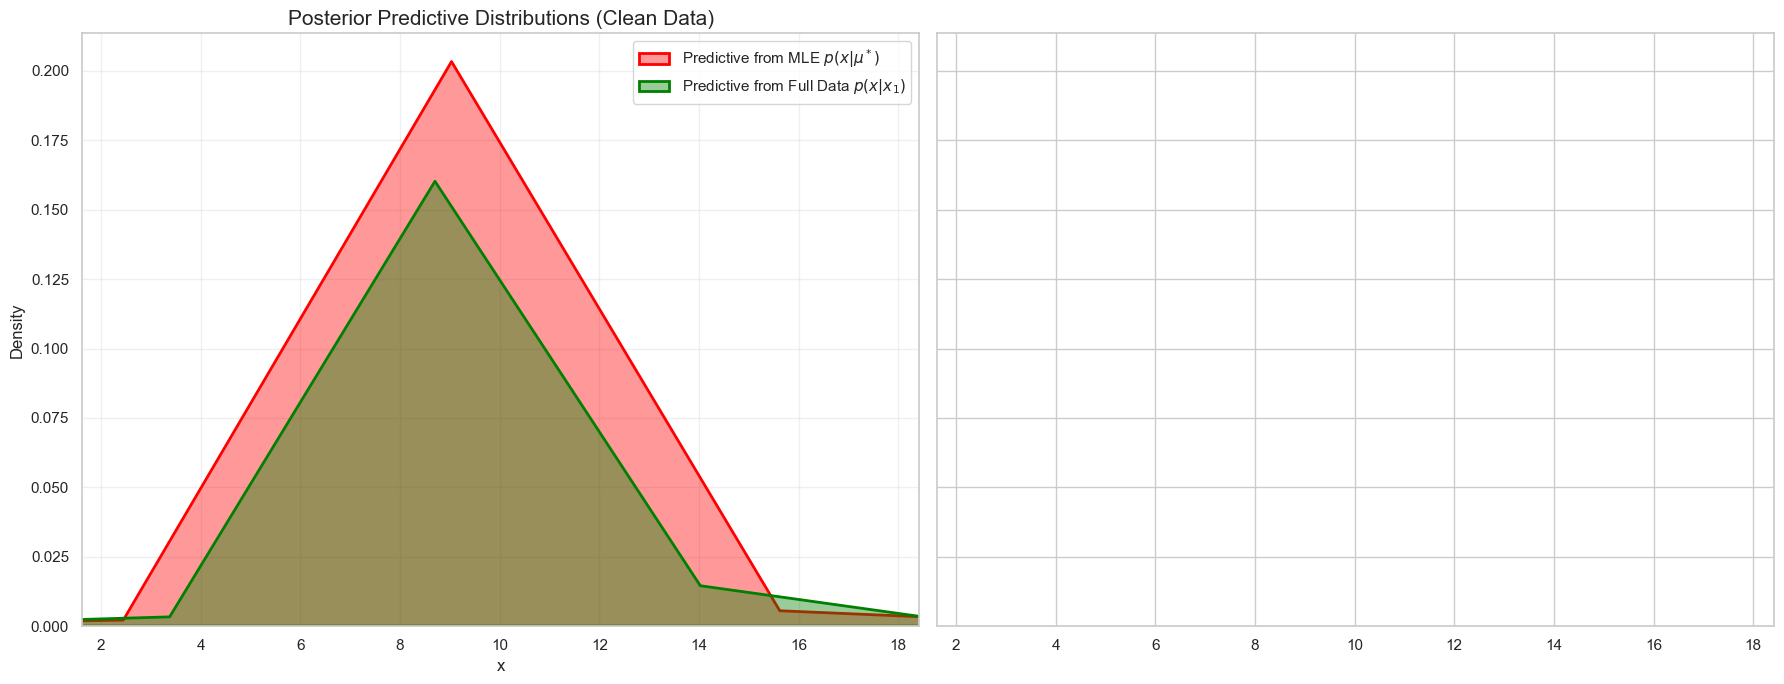

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
colors = sns.color_palette("viridis_r", n_colors=len(outlier_datasets))

sns.kdeplot(x_pred_from_mle, label="Predictive from MLE $p(x|\\mu^*)$", color='red', lw=2, fill=True, alpha=0.4, ax=axes[0], bw_adjust=bw_smoother)
# Plot the predictive distribution from the full clean data, p(x|x₁)
# Assumes predictive_chains[0] corresponds to the clean dataset
sns.kdeplot(predictive_chains[0], label="Predictive from Full Data $p(x|x_1)$", color='green', lw=2, fill=True, alpha=0.4, ax=axes[0], bw_adjust=bw_smoother)
axes[0].set_title("Posterior Predictive Distributions (Clean Data)", fontsize=15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Set consistent, dynamic x-axis limits for both plots
all_preds_for_plot = np.concatenate([x_pred_from_mle] + predictive_chains)
x_min = np.percentile(all_preds_for_plot, 1)
x_max = np.percentile(all_preds_for_plot, 99)
padding = (x_max - x_min) * 0.1
xlim = (x_min - padding, x_max + padding)
axes[0].set_xlim(xlim)
axes[1].set_xlim(xlim)

plt.tight_layout()
plt.show()


--- Visualizing Posterior Distributions ---


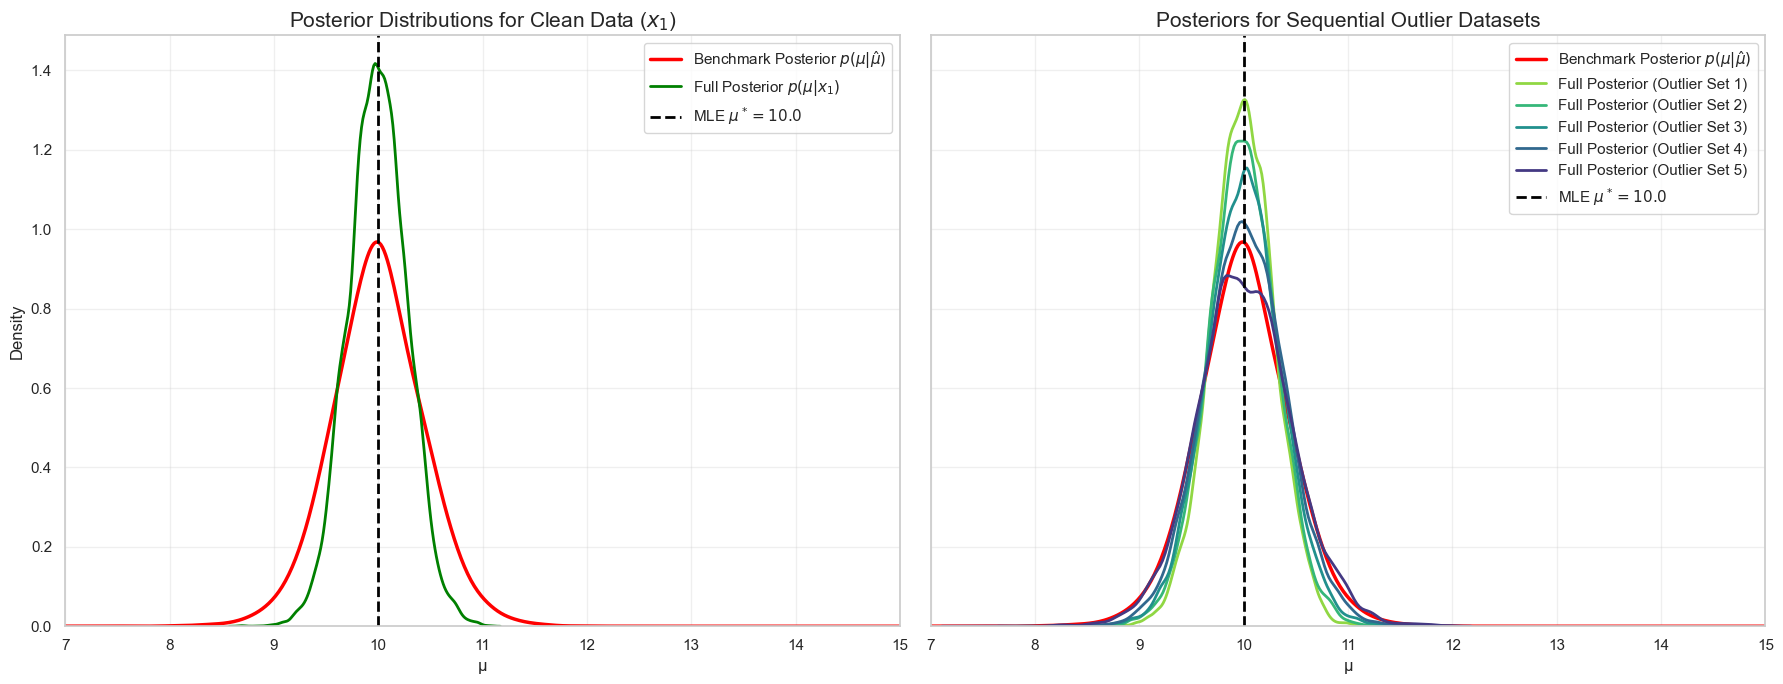

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
xlimit = 20  # Set a limit for the x-axis
bw = 0.5
# Left: x1
axes[0].set_xlim(5, 35)
sns.kdeplot(
    x_pred_mle1, label="Posterior Predictive $p(x|μ^*(x_1))$",
    color='red', lw=2, fill=True, alpha=0.4, bw_adjust=bw, cut=3, gridsize=1000, ax=axes[0]
)
sns.kdeplot(
    x_pred_x1, label="Posterior Predictive $p(x|x_1)$",
    color='green', lw=2, fill=True, alpha=0.4, bw_adjust=bw, cut=3, gridsize=1000, ax=axes[0]
)
axes[0].set_title("Posterior Predictive Distributions for x (x₁)", fontsize=15)
axes[0].set_xlabel("x")
axes[0].set_ylabel("Density")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: x2
axes[1].set_xlim(5,35)
sns.kdeplot(
    x_pred_mle2, label="Posterior Predictive $p(x|μ^*(x_2))$",
    color='red', lw=2, fill=True, alpha=0.4, bw_adjust=bw, cut=3, gridsize=1000, ax=axes[1]
)
sns.kdeplot(
    x_pred_x2, label="Posterior Predictive $p(x|x_2)$",
    color='green', lw=2, fill=True, alpha=0.4, bw_adjust=bw, cut=3, gridsize=1000, ax=axes[1]
)
axes[1].set_title("Posterior Predictive Distributions for x (x₂)", fontsize=15)
axes[1].set_xlabel("x")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
